In [229]:
import numpy as np # 
import pandas as pd # For working with spreadsheet data
from matplotlib import pyplot as plt # For plotting data
import matplotlib.dates as mdates
import datetime

from sklearn.model_selection import train_test_split # For separating the data into training and testing sets
from sklearn.preprocessing import MinMaxScaler # For preprocessing the data before it's passed to the model
from sklearn.svm import SVR # One of the algorithms being used to forecast the price
from sklearn.model_selection import cross_val_score # Metric to test the model's accuracy when hyperparameter tuning
from sklearn.metrics import mean_squared_error, r2_score # Metrics to see the model's accuracy after it's been trained

# For the deep learning model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.optimizers import Adam

# For hyperparameter optimization
import optuna

In [431]:
# Getting the spreadsheet data
data = pd.read_csv("Ethereum Data/ETH_5Years.csv")

In [231]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-31,197.649002,198.337997,196.531006,197.380997,197.380997,1442380000
1,2018-11-01,197.537003,203.753998,197.328003,198.871994,198.871994,1336700000
2,2018-11-02,198.981995,201.268997,198.755005,200.634995,200.634995,1451870000
3,2018-11-03,200.740005,200.740005,199.524994,200.186005,200.186005,1307150000
4,2018-11-04,200.158005,211.272003,198.985992,207.485992,207.485992,1749300000
...,...,...,...,...,...,...,...
1822,2023-10-27,1803.794922,1804.135864,1751.440063,1780.045288,1780.045288,7493399771
1823,2023-10-28,1780.084229,1800.605347,1773.436646,1776.618164,1776.618164,4226112731
1824,2023-10-29,1776.563965,1810.488647,1766.052979,1795.546021,1795.546021,4358528382
1825,2023-10-30,1795.589111,1829.249512,1779.364502,1810.088623,1810.088623,7534051038


# Cleaning the Data

In [432]:
# Deleting this row since it isn't important here
data.drop(['Adj Close'], axis = 1, inplace = True)

In [233]:
data

,Date,Open,High,Low,Close,Volume
0,2018-10-31,197.649002,198.337997,196.531006,197.380997,1442380000
1,2018-11-01,197.537003,203.753998,197.328003,198.871994,1336700000
2,2018-11-02,198.981995,201.268997,198.755005,200.634995,1451870000
3,2018-11-03,200.740005,200.740005,199.524994,200.186005,1307150000
4,2018-11-04,200.158005,211.272003,198.985992,207.485992,1749300000
...,...,...,...,...,...,...
1822,2023-10-27,1803.794922,1804.135864,1751.440063,1780.045288,7493399771
1823,2023-10-28,1780.084229,1800.605347,1773.436646,1776.618164,4226112731
1824,2023-10-29,1776.563965,1810.488647,1766.052979,1795.546021,4358528382
1825,2023-10-30,1795.589111,1829.249512,1779.364502,1810.088623,7534051038


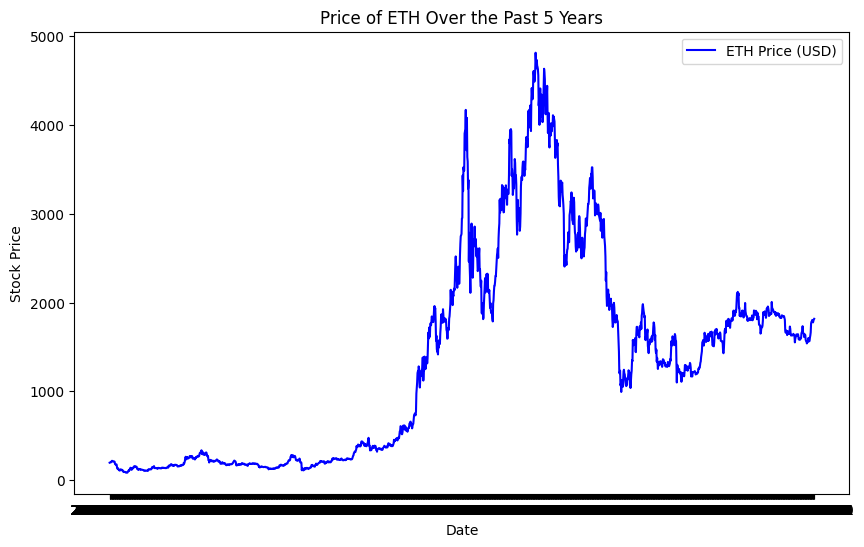

In [234]:
# Plotting ETH price
plt.figure(figsize = (10, 6))
plt.plot(data['Date'], data['Close'], label = "ETH Price (USD)", color = "blue")

plt.title("Price of ETH Over the Past 5 Years")
plt.xlabel("Date")
plt.xticks()
plt.ylabel("Stock Price")
plt.legend()

plt.show()

In [235]:
data['Close']

0        197.380997
1        198.871994
2        200.634995
3        200.186005
4        207.485992
           ...     
1822    1780.045288
1823    1776.618164
1824    1795.546021
1825    1810.088623
1826    1816.458984
Name: Close, Length: 1827, dtype: float64

In [236]:
data

,Date,Open,High,Low,Close,Volume
0,2018-10-31,197.649002,198.337997,196.531006,197.380997,1442380000
1,2018-11-01,197.537003,203.753998,197.328003,198.871994,1336700000
2,2018-11-02,198.981995,201.268997,198.755005,200.634995,1451870000
3,2018-11-03,200.740005,200.740005,199.524994,200.186005,1307150000
4,2018-11-04,200.158005,211.272003,198.985992,207.485992,1749300000
...,...,...,...,...,...,...
1822,2023-10-27,1803.794922,1804.135864,1751.440063,1780.045288,7493399771
1823,2023-10-28,1780.084229,1800.605347,1773.436646,1776.618164,4226112731
1824,2023-10-29,1776.563965,1810.488647,1766.052979,1795.546021,4358528382
1825,2023-10-30,1795.589111,1829.249512,1779.364502,1810.088623,7534051038


In [433]:
# Creating a constant to store the number of days in the future to predict the price
DAYS_IN_FUTURE = 3
length = len(data)

# Adding an extra column for the future price and setting the value of each row equal to the 'Close' value DAYS_IN_FUTURE days in the future
future_price = [data['Close'].loc[x + DAYS_IN_FUTURE] for x in range(length - DAYS_IN_FUTURE)]

# Getting rid of last DAYS_IN_FUTURE rows since there is no future price value for those days
for x in range(DAYS_IN_FUTURE):
    data.drop(length - x - 1, inplace = True)

In [434]:
# Creating the column in the DataFrame
data[f"{DAYS_IN_FUTURE} Days Future Price"] = future_price
data

,Date,Open,High,Low,Close,Volume,3 Days Future Price
0,2018-10-31,197.649002,198.337997,196.531006,197.380997,1442380000,200.186005
1,2018-11-01,197.537003,203.753998,197.328003,198.871994,1336700000,207.485992
2,2018-11-02,198.981995,201.268997,198.755005,200.634995,1451870000,209.091003
3,2018-11-03,200.740005,200.740005,199.524994,200.186005,1307150000,218.451996
4,2018-11-04,200.158005,211.272003,198.985992,207.485992,1749300000,217.182999
...,...,...,...,...,...,...,...
1819,2023-10-24,1766.014648,1852.684448,1758.690063,1784.437500,15888690475,1780.045288
1820,2023-10-25,1784.905029,1814.484741,1762.147095,1787.397583,9439066475,1776.618164
1821,2023-10-26,1787.481934,1865.095215,1764.013062,1804.039307,11196672635,1795.546021
1822,2023-10-27,1803.794922,1804.135864,1751.440063,1780.045288,7493399771,1810.088623


# Preparing the Data

In [435]:
# Converting the date value to an integer so it can be used by the model
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].map(mdates.date2num)
# Storing the cleaned data so it can be used again in the LSTM model
cleaned_data = data

In [436]:
# Storing the independent variables and dependent variable
features = data[['Open', 'Date', 'Close']]
target = data[f'{DAYS_IN_FUTURE} Days Future Price'].values
# Reshaping the input data so it can be passed to the model
features = features.to_numpy()

In [437]:
# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.4)

In [ ]:
# y_train_reshaped = np.ravel(y_train)
# x_train

In [438]:
# Scale the features data for preprocessing
scaler = MinMaxScaler(feature_range = (0, 1))

# x_train = x_train.reshape(-1, 1)
# x_test = x_test.reshape(-1, 1)

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

# SVR Hyperparameter Optimization

In [439]:
# Train the SVR model in a way that optimizes the model's hyperparameters
def optimize_svr(trial):
    # Suggesting possible values to test for each hyperparameter
    c = trial.suggest_float("C", 1000, 5000, log = True)
    gamma = trial.suggest_float("gamma", 1e-5, 1e-1, log = True)
    
    # Creating the model to use for testing
    model = SVR(kernel = 'rbf', C = c, gamma = gamma)
    # Calculate how well a given model with certain hyperparameter performs
    score = np.mean(cross_val_score(model, x_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error'))
    accuracy = score.mean()
    
    # The metric being used to determine how effective a model is with certain hyperparameters
    return accuracy

In [440]:
# Creating the study object
study = optuna.create_study(direction = 'maximize')
# Experimenting with different hyperparameter values to find the optimal values
study.optimize(optimize_svr, n_trials = 150)

# Information about the most successful trial
print("Best trial:")
trial = study.best_trial

# The model hyperparameters that lead to maximum accuracy
print(f"Value: {trial.value}")
print("Params:")
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2023-11-13 16:10:31,339] A new study created in memory with name: no-name-28ca86f9-899e-4146-bdc5-545b00a3d1da
[I 2023-11-13 16:10:31,613] Trial 0 finished with value: -1237071.0279482417 and parameters: {'C': 1321.8839169402759, 'gamma': 0.00021865176188119118}. Best is trial 0 with value: -1237071.0279482417.
[I 2023-11-13 16:10:31,853] Trial 1 finished with value: -625048.2794389308 and parameters: {'C': 1751.5161535751147, 'gamma': 0.000991106746596981}. Best is trial 1 with value: -625048.2794389308.
[I 2023-11-13 16:10:32,089] Trial 2 finished with value: -874189.3378001802 and parameters: {'C': 1726.2775206405659, 'gamma': 0.0006045450024663561}. Best is trial 1 with value: -625048.2794389308.
[I 2023-11-13 16:10:32,356] Trial 3 finished with value: -1371119.6562056304 and parameters: {'C': 1437.3792681153673, 'gamma': 3.798516172400082e-05}. Best is trial 1 with value: -625048.2794389308.
[I 2023-11-13 16:10:32,657] Trial 4 finished with value: -705632.776431824 and paramete

Best trial:
Value: -18318.73067763834
Params:
    C: 4974.031182109689
    gamma: 0.09698272852078622


In [441]:
# Getting the best values of each hyperparameter 
params = study.best_params

# Building and Running the SVR Model

In [442]:
def build_model():
    # Passing in optimal hyperparameters
    model = SVR(kernel = 'rbf', C = params['C'], gamma = params['gamma'])
    # scaler_target = MinMaxScaler(feature_range=(0, 1))
    # y_train_reshaped_scaled = scaler_target.fit_transform(y_train_reshaped.reshape(-1, 1)).ravel()
    # Fitting the model to the training data set
    model.fit(x_train_scaled, y_train)
    
    return model

In [443]:
# Creating the model
model = build_model()

In [444]:
# Testing the model on the test set
predictions = model.predict(x_test_scaled)

In [445]:
# Evaluating its performance
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 18054.98699634577
R-squared: 0.9868763947837693


In [446]:
print(predictions)
print("--------------------------------------")
print(y_test)

[ 136.80471528 3089.28292918  380.93448333  136.84075986 2348.46990061
 1828.94801482 2431.05635028  238.8778701   139.27937397 1264.43048649
 4194.63298096 1178.05718196 1303.08269488 1285.30164778 1543.8955039
 2039.12932126   93.40592804 1865.58138877 1704.93154927  181.25527272
 1672.89064922  146.41423842  122.29908858 3196.03957023 1966.33176128
 3287.92221641  208.4135787  2787.20083411  231.65444562 2875.50598263
  134.19814224  176.77968141  367.63684302 1441.36424463 3219.72347539
  454.02418897  113.8919216  4449.70229911  242.73972337 1499.79259137
 1843.82432525 1272.41882898 2491.16134436  261.58001618  152.93021053
  129.073926    149.87863317 3717.49653911 2784.48137123  476.56021359
 1854.75038606  246.01901115  238.44466965  225.73756232  202.97338914
 2249.65676145 2715.37019708 1821.1815848  2415.72751988 1743.55370889
 1560.6175238   382.15196621 3187.30091145  217.21548401 1879.98549972
  611.26210542  260.873935   1617.6055775   240.74302067 1793.47096951
 1551.8

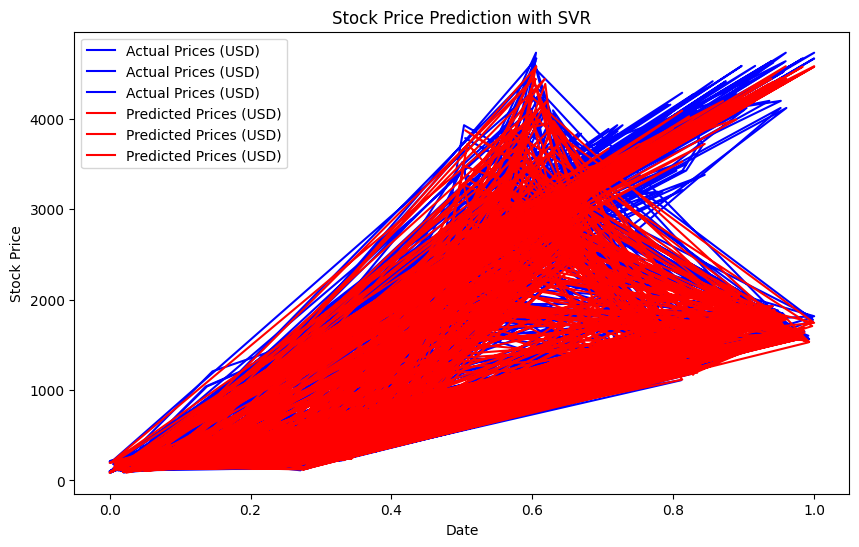

In [447]:
# Plotting performance
plt.figure(figsize = (10, 6))
plt.plot(x_test_scaled, y_test, label = "Actual Prices (USD)", color = "blue")
plt.plot(x_test_scaled, predictions, label = "Predicted Prices (USD)", color = "red")

plt.t, itle("Stock Price Prediction with SVR")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()

plt.show()

Not bad, accuracy is around 98%.
Let's try using an LSTM RNN to see if it can beat the SVR

# Setting up the Data

In [391]:
cleaned_data

,Date,Open,High,Low,Close,Volume,3 Days Future Price
0,17835.0,197.649002,198.337997,196.531006,197.380997,1442380000,200.186005
1,17836.0,197.537003,203.753998,197.328003,198.871994,1336700000,207.485992
2,17837.0,198.981995,201.268997,198.755005,200.634995,1451870000,209.091003
3,17838.0,200.740005,200.740005,199.524994,200.186005,1307150000,218.451996
4,17839.0,200.158005,211.272003,198.985992,207.485992,1749300000,217.182999
...,...,...,...,...,...,...,...
1819,19654.0,1766.014648,1852.684448,1758.690063,1784.437500,15888690475,1780.045288
1820,19655.0,1784.905029,1814.484741,1762.147095,1787.397583,9439066475,1776.618164
1821,19656.0,1787.481934,1865.095215,1764.013062,1804.039307,11196672635,1795.546021
1822,19657.0,1803.794922,1804.135864,1751.440063,1780.045288,7493399771,1810.088623
